In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl

# our functions
import predict_Beta_I
import choice_start_day

import warnings
warnings.filterwarnings(action='ignore')

# to account for updates when files change
%load_ext autoreload
%autoreload 2

# Main programm

In [ ]:
def plot_one(ax, 
             predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta,
             seed_number, execution_time,
             median_values, lower_bound, upper_bound):
    '''
    Plotting the graph for a seed.
    
    Parameters:

    - ax -- area for the plot
    - predicted_days -- predicted days
    - seed_df -- DataFrame of seed, created by the regular network
    - predicted_I -- predicted trajectory of the Infected compartment
    - beggining_beta -- predicted initial values of Beta
    - predicted_beta -- predicted values of Beta
    - seed_number -- seed number        
    - execution_time -- time taken to predict Beta   
    - median_values -- sample mean of predicted_I on a specific day
    - lower_bound -- upper boundary of the interval (3 standard deviations of predicted_I on a specific day)
    - upper_bound -- lower boundary of the interval (3 standard deviations of predicted_I on a specific day)
    '''

    # when shifting forecasts, sometimes NaN values appear here
    predicted_I[np.isnan(predicted_I)] = 0.0  
    predicted_beta[np.isnan(predicted_beta)] = 0.0
    beggining_beta[np.isnan(beggining_beta)] = 0.0

    # find the maximum and its index
    predicted_peak_I = max(predicted_I[0])
    predicted_peak_day = predicted_days[0] + np.argmax(predicted_I[0])
    actual_I = seed_df.iloc[:]['I'].values 
    actual_peak_I = max(actual_I)
    actual_peak_day = np.argmax(actual_I)+1

    peak = [actual_peak_I, predicted_peak_I,actual_peak_day,predicted_peak_day] 

    # calculate RMSE for Infected and Beta values
    actual_I = seed_df.iloc[predicted_days[0]:]['I'].values 
    rmse_I = rmse(actual_I, predicted_I[0])
    actual_Beta = seed_df.iloc[predicted_days[0]:]['Beta'].values 
    rmse_Beta = rmse(actual_Beta, predicted_beta)   

    # display boundary of switch 
    ax.axvline(predicted_days[0], color='red',ls=':')

    if predicted_I.shape[0] > 1:
        # display trajectories of the stochastic mathematical model
        for i in range(predicted_I.shape[0]-1):
            ax.plot(predicted_days, predicted_I[i+1], color='tab:orange', ls='--', 
                    alpha=0.3, label='Predicted I (stoch.)' if i == 0 else '')

        # add vertical lines with tick marks for confidence intervals
        for day in range(0, len(predicted_days), 5): 
            ax.errorbar(predicted_days[day], median_values[day],
                        yerr=[[median_values[day] - lower_bound[day]], 
                            [upper_bound[day] - median_values[day]]], 
                        fmt='o', color='black', capsize=2, markersize=2, elinewidth=1, 
                        alpha=0.6, label='$\mu \pm 3\sigma$' if day == 0 else '')

    # display actual and predicted Infected values
    ax.plot(seed_df.index, seed_df.iloc[:]['I'].values , color='tab:blue', 
            label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='red', ls='-', 
              alpha=0.9, label='Predicted I (det.)')
    
    # add axis labels
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # display actual and predicted Beta values
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='--', 
              alpha=0.4, label='Actual Beta')
    
    if len(beggining_beta) > 0:
        given_days = np.arange(predicted_days[0])
        ax_b.plot(given_days, beggining_beta,color='green', ls='--', 
                  alpha=0.7, label='Predicted Beta ')
    ax_b.plot(predicted_days, predicted_beta,color='green', ls='--', 
              alpha=0.7, label='Predicted Beta ')
    ax_b.set_ylabel("Beta", color='green')
    
    # add legend and titles
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed_number}, Switch day {predicted_days[0]}\n'+
                 f'Peak I (act.):{actual_peak_I:.2f}, '+
                   f'Peak day (act.):{actual_peak_day:.2f}, \n' +
                 f'Peak I (pred.):{predicted_peak_I:.2f}, '+
                   f'Peak day (pred.):{predicted_peak_day:.2f}, \n' +
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Predict time: {execution_time:.2e}' ,fontsize=10)
    return rmse_I, rmse_Beta, peak

def main_f(I_prediction_method, stochastic, count_stoch_line, 
           beta_prediction_method, type_start_day, seed_numbers,
           show_fig_flag, save_fig_flag = False):
    '''
    Main function
    
    Parameters:
    
    - I_prediction_method -- mathematical model for constructing the trajectory of Infected
        ['seir']
    - stochastic -- indicator of the presence of predicted stochastic trajectories of Infected 
    - count_stoch_line -- number of predicted stochastic trajectories of Infected 
    - beta_prediction_method -- method for predicting Beta values
        ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        'median beta',
        'regression (day)'
        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    - type_start_day -- type of choosing the switching day for the model 
        (changing or constant)
        ['roll_var', 
         'norm_var', 
         'roll_var_seq', 
         'roll_var_npeople', 
         40,
         50,
         60]
    - seed_numbers -- seed numbers for the experiments
    - show_fig_flag -- flag to show the plots
    - save_fig_flag -- flag to save the plots
    
    Output:
        Graph for seeds.
    '''
     # setting always constant values for mathematical model parameters
    sigma = 0.1
    gamma = 0.08
    if len(seed_numbers) > 1:
        row_n = len(seed_numbers)//2+math.ceil(len(seed_numbers)%2)
        fig, axes = plt.subplots(row_n, 2, figsize=(15, 4*row_n))
        axes = axes.flatten()
    
    # declaration of the folder with DataFrames of seeds created by the regular network
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'
    
    # list of RMSE Beta and I for each seed 
    all_rmse_I = []
    all_rmse_Beta = []
    all_peak = []
    start_days = []
    execution_time = []
    print(beta_prediction_method)
    for idx, seed_number in enumerate(seed_numbers):
        
        # read the DataFrame of the seed: S,[E],I,R,Beta
        seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed_number}.csv')
        seed_df = seed_df[pd.notna(seed_df['Beta'])]

        # switch moment
        start_day = choice_start_day.choose_method(seed_df, type_start_day)
        start_days.append(start_day)
        # choosing the days for prediction
        predicted_days = np.arange(start_day, seed_df.shape[0])
        
        start_time = time.time()
        # prediction of Beta values and calculation of prediction time
        beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            I_prediction_method, seed_df, beta_prediction_method, 
                            predicted_days, stochastic, count_stoch_line, sigma, gamma)

        if (beta_prediction_method != 'regression (day, SEIR, previous I)') & (
            beta_prediction_method != 'lstm (day, E, previous I)'):
             # extract compartment values on the switch day
            y = seed_df.iloc[predicted_days[0]].drop('Beta')

            # predict the Infected compartment trajectory
            _,_,predicted_I[0],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                    predicted_days, 
                                    predicted_beta, sigma, gamma, 'det')
            if stochastic:
                for i in range(count_stoch_line):
                    _,_,predicted_I[i+1],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                                predicted_days, 
                                                predicted_beta, sigma, gamma, 'stoch')
        end_time = time.time()
        execution_time.append(end_time - start_time)

        if len(seed_numbers) > 1:
            # plot graph for seed_number
            ax = axes[idx]
            rmse_I, rmse_Beta, peak = plot_one(ax, predicted_days, seed_df, 
                                            predicted_I, beggining_beta, predicted_beta, 
                                            seed_number, end_time - start_time, 0,0,0)        
            all_rmse_I.append(rmse_I)
            all_rmse_Beta.append(rmse_Beta)
            all_peak.append(peak)
    
    if len(seed_numbers) > 1:
        # add overall title
        fig.suptitle(f'Switch {start_day} day, \n'+
                    f'I_prediction_method:{I_prediction_method}, \n'+
                    f'beta_prediction_method: {beta_prediction_method}',fontsize=15)
        plt.tight_layout()
        
        # save the plots in pdf
        if save_fig_flag:
            beta_prediction_method = beta_prediction_method.replace(';\n','')
            plt.savefig(f'plots_var/seeds1 {beta_prediction_method}.pdf', 
                        format='pdf', dpi=300, bbox_inches='tight')
        
        # show the plots
        if show_fig_flag:
            plt.show()
        else:
            plt.close(fig)

        return all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days
    else :
        return predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, end_time - start_time



# start day - changing


### Save RMSE Infected и Beta, peaks Infected (hight) and Day (time), predicted time, start day for all beta_prediction_method

In [ ]:
'''
seeds = set()
seeds.update(range(int(0), int(30)))
types_start_day = ['roll_var_seq', 
                   'roll_var_npeople']
beta_prediction_methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']   
labels_beta_prediction_methods = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']               

for type_start_day in types_start_day:
    methods = beta_prediction_methods
    new_labels = labels_beta_prediction_methods
    for beta_prediction_method,new_labels in zip(methods, new_labels):
        all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days = main_f('seir', False, 0, beta_prediction_method, type_start_day, seeds, False, False)
        # creating a dataframe for peaks
        all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 'actual_peak_day', 'predicted_peak_day'])
        # creating a dataframe for peaks RMSE, predicted time, start day
        print(len(all_rmse_I),len(all_rmse_Beta), len(execution_time), len(start_days))
        rmse_df = pd.DataFrame({
            'rmse_I': all_rmse_I,
            'rmse_Beta': all_rmse_Beta,
            'time_predict': execution_time,
            f'{type_start_day}': start_days})

        # merging dataframes
        results = pd.concat([rmse_df, all_peak], axis=1)
        results.to_csv(f'results/type_start_day = {type_start_day}/{new_labels}_results.csv', index=False)''
'''

### Boxplot RMSE for Infected


type_start_day = roll_var_npeople

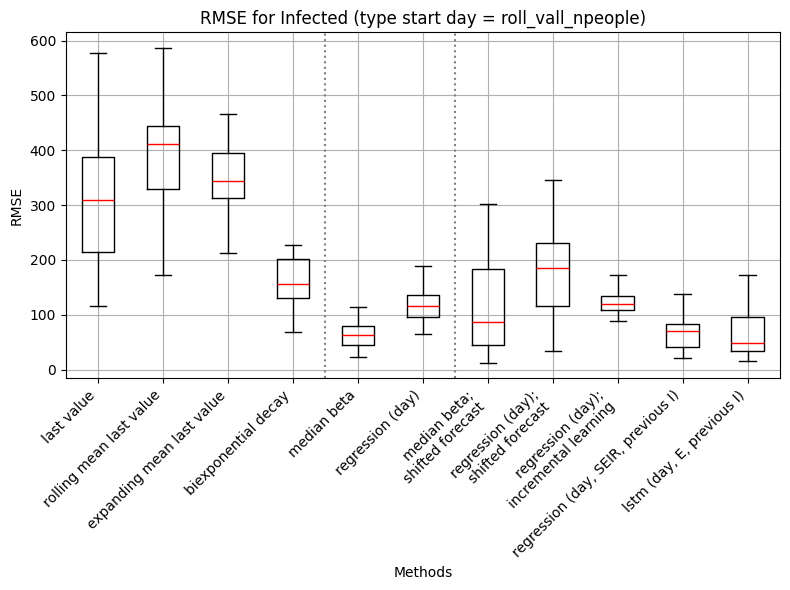

<Figure size 640x480 with 0 Axes>

In [ ]:
methods = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 
    
    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']
new_labels = ['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay', 
    
    'median_beta',
    'regression_day',

    'median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']

switch = 'type_start_day = roll_var_npeople'

rmse_df = pd.DataFrame()
for beta_prediction_method,new_labels in zip(methods, new_labels):
    # loading data from CSV
    df = pd.read_csv(f'results/{switch}/{new_labels}_results.csv')
    # add data to DataFrame with the column name as the method
    rmse_df[f"{beta_prediction_method}"] = df['rmse_I']

# creating a boxplot
plt.figure(figsize=(8,6)) 
box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='red'),
                  widths=0.5)

plt.title(f'RMSE for Infected (type start day = roll_vall_npeople)')
plt.xlabel('Methods')
plt.ylabel('RMSE')
plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
        labels=methods, rotation=45, ha='right')
plt.axvline(4.5, ls=':', color='gray')
plt.axvline(6.5, ls=':', color='gray')
plt.tight_layout()
plt.grid()
plt.show()

#plt.savefig(f'results/type_start_day = roll_var_npeople/rmse_I_boxplot.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')    

Median RMSE I for last_value 309.3379823892012
Median RMSE I for rolling_mean_last_value 411.8019682392767
Median RMSE I for expanding_mean_last_value 343.88859784922465
Median RMSE I for biexponential_decay 156.05185476019625
Median RMSE I for median_beta 63.132295191818315
Median RMSE I for regression_day 115.00564494596907
Median RMSE I for median_beta_shifted_forecast 86.34916245706603
Median RMSE I for regression_day_shifted_forecast 184.3235819875726
Median RMSE I for regression_day_incremental_learning 119.91465189574632
Median RMSE I for regression_day_SEIR_previous_I 70.8644916972514
Median RMSE I for lstm_day_E_previous_I 47.989491611898245


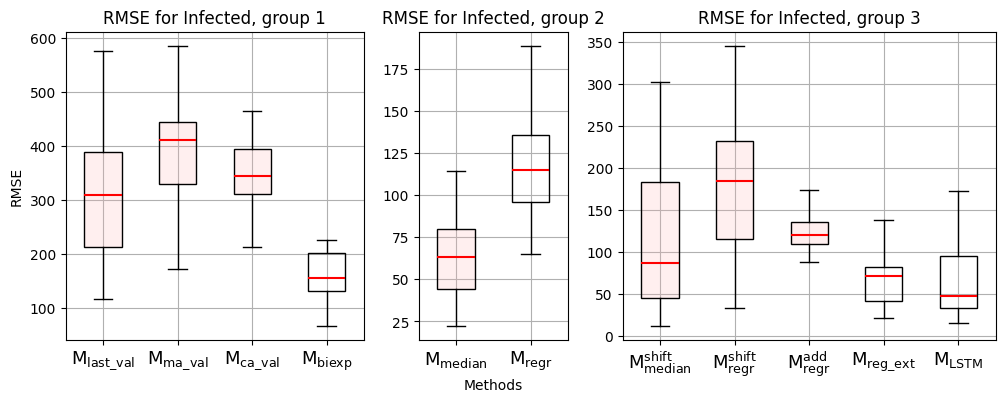

In [ ]:
methods = [['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']]
new_labels = [['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay'], 

    ['median_beta',
    'regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']]
switch = 'type_start_day = roll_var_npeople'

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.5]) 
for i in range(len(methods)):

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # loading data from CSV
        df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
        print(f'Median RMSE I for {new_label}', df['rmse_I'].median())
    
    # creating a boxplot
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=False, 
                      medianprops=dict(color='red',linewidth=1.5), 
                      widths=0.5, patch_artist=True)
    median_c = (1.0, 0.7, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
        
    ax.set_title(f'RMSE for Infected, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    ax.grid()  
   
#plt.savefig(f'results/{switch}/rmse_I_3.pdf', 
#            format='pdf', bbox_inches='tight')

### Boxplot RMSE for Beta


type_start_day = roll_var_npeople

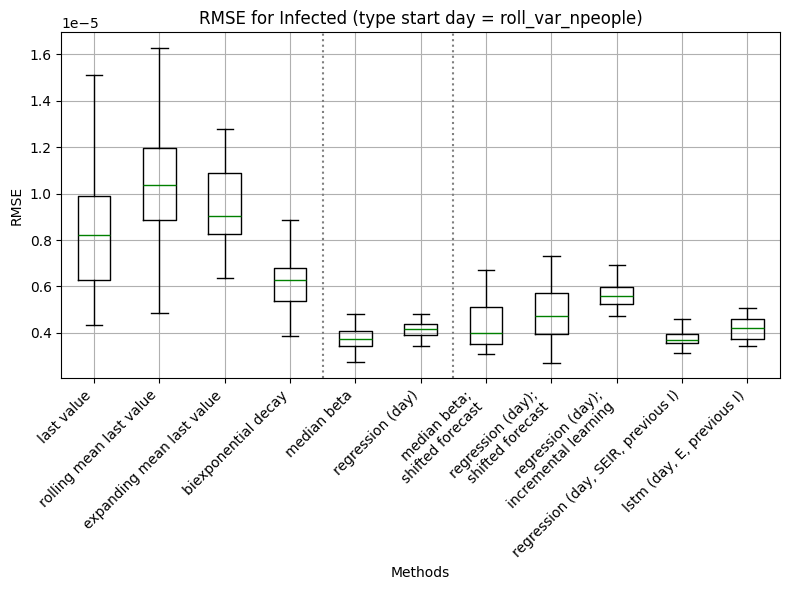

In [ ]:
methods = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 
    
    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']
new_labels = ['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay', 
    
    'median_beta',
    'regression_day',

    'median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']

rmse_df = pd.DataFrame()
for beta_prediction_method,new_labels in zip(methods, new_labels):
    # loading data from CSV
    df = pd.read_csv(f'results/{switch}/{new_labels}_results.csv')
    # add data to DataFrame with the column name as the method
    rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']

# creating a boxplot
plt.figure(figsize=(8,6))
box = plt.boxplot(rmse_df, showfliers=False, 
                  medianprops=dict(color='green'),widths=0.5)


plt.title(f'RMSE for Infected (type start day = roll_var_npeople)')
plt.xlabel('Methods')
plt.ylabel('RMSE')
plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
        labels=methods, rotation=45, ha='right')
plt.axvline(4.5, ls=':', color='gray')
plt.axvline(6.5, ls=':', color='gray')
plt.tight_layout()
plt.grid()
plt.show()

#plt.savefig(f'results/type_start_day = roll_var_npeople/rmse_Beta_boxplot.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')    


Median RMSE Beta for last_value 8.235234350751468e-06
Median RMSE Beta for rolling_mean_last_value 1.0364678732531097e-05
Median RMSE Beta for expanding_mean_last_value 9.051364339178766e-06
Median RMSE Beta for biexponential_decay 6.294594429854524e-06
Median RMSE Beta for median_beta 3.7198801666434465e-06
Median RMSE Beta for regression_day 4.186300985784922e-06
Median RMSE Beta for median_beta_shifted_forecast 4.011823825699053e-06
Median RMSE Beta for regression_day_shifted_forecast 4.7367521611861115e-06
Median RMSE Beta for regression_day_incremental_learning 5.5854385485009145e-06
Median RMSE Beta for regression_day_SEIR_previous_I 3.7039159453114235e-06
Median RMSE Beta for lstm_day_E_previous_I 4.216700250324113e-06


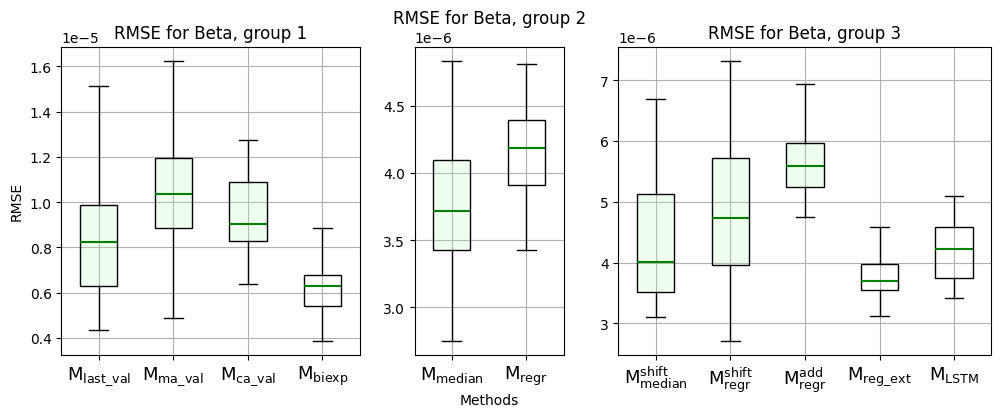

In [ ]:
methods = [['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']]
new_labels = [['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay'], 

    ['median_beta',
    'regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']]

switch = 'type_start_day = roll_var_npeople'

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[4,2,5]) 
for i in range(len(methods)):

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # loading data from CSV
        df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']
        print(f'Median RMSE Beta for {new_label}', df['rmse_Beta'].median())

    # creating a boxplot
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=False, 
                      medianprops=dict(color='green',linewidth=1.5), 
                      widths=0.5, patch_artist=True)
    median_c = (0.7, 1.0, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  

    ax.set_title(f'RMSE for Beta, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    ax.grid()
    
   
#plt.savefig(f'results/{switch}/rmse_Beta_3.pdf', 
#            format='pdf', bbox_inches='tight')

### Show peaks plots

type_start_day = roll_var_npeople

In [10]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']

switch = 'type_start_day = roll_var_npeople'

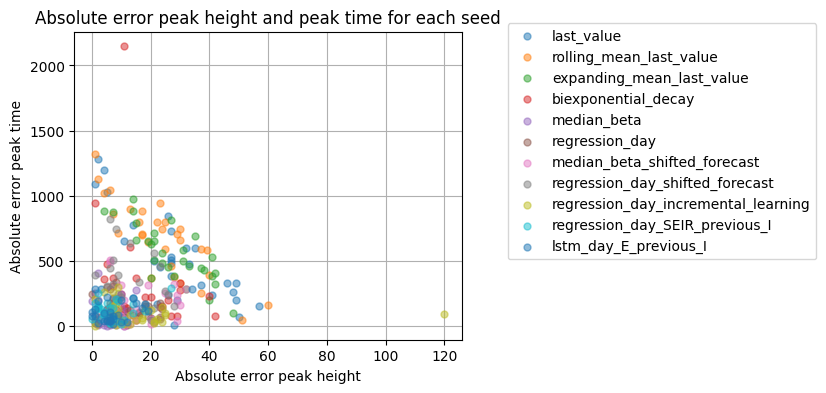

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name, zorder=3)

ax.grid(True, zorder=0)    
ax.set_title('Absolute error peak height and peak time for each seed')    
ax.set_xlabel('Absolute error peak height')
ax.set_ylabel('Absolute error peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

#plt.savefig(f'results/type_start_day = roll_var_npeople/absolute_error_peaks.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')

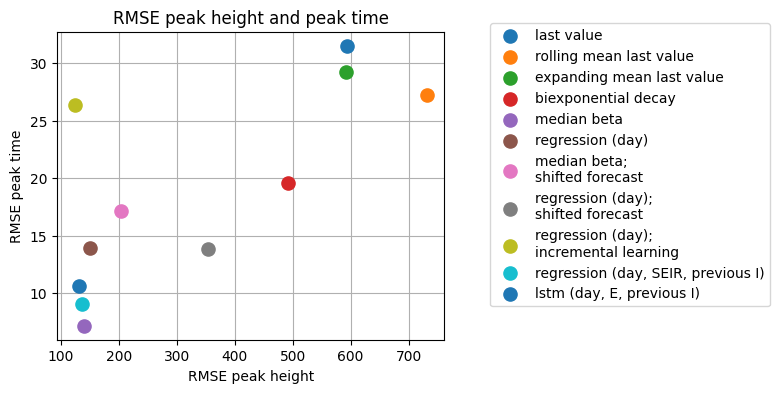

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{name}_results.csv')
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], p_df.iloc[:]['predicted_peak_I']))
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], p_df.iloc[:]['predicted_peak_day']))
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name, zorder=3)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid(True, zorder=0)    

#plt.savefig(f'results/type_start_day = roll_var_npeople/rmse_peaks.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')


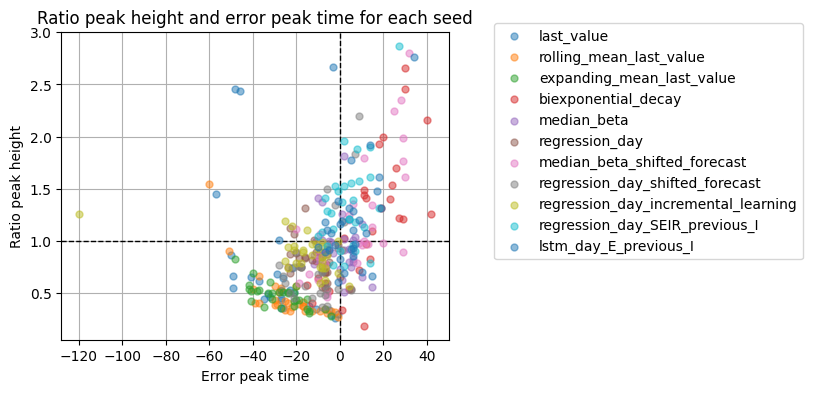

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

for name in new_labels:
    p_df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{name}_results.csv')
    ph = []
    pt = []
    ph.append([p_df.iloc[:]['actual_peak_I']/p_df.iloc[:]['predicted_peak_I']])
    pt.append([p_df.iloc[:]['actual_peak_day']-p_df.iloc[:]['predicted_peak_day']])
    
    ax.scatter(pt,ph, marker='.', s=100,  alpha=0.5, label=name, zorder=3)
ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Error peak time')
ax.set_ylabel('Ratio peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.axvline(x=0, color='black', linestyle='--', linewidth=1, 
           label='Difference of peak time=0')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1, 
           label='Ratio of peak height=1')
ax.grid(True, zorder=0)    

#plt.savefig(f'results/type_start_day = roll_var_npeople/ratio_and_error_peaks.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')


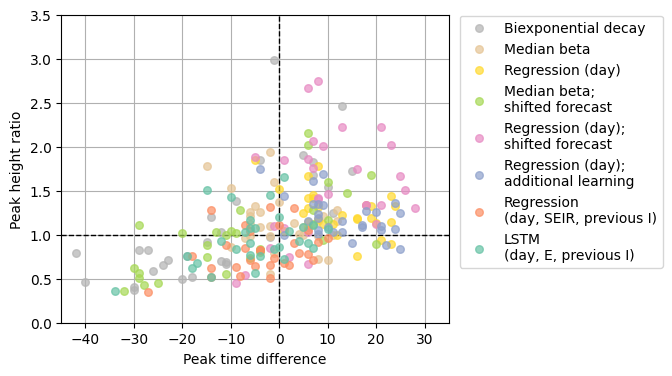

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', linewidth=1)

methods = ['Biexponential decay', 'Median beta', 'Regression (day)',

            'Median beta;\nshifted forecast',
            'Regression (day);\nshifted forecast',
            'Regression (day);\nadditional learning',
            'Regression\n(day, SEIR, previous I)',       
            'LSTM\n(day, E, previous I)']

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value','biexponential_decay', 

                'median_beta','regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']


switch = 'type_start_day = roll_var_npeople'

cmap = mpl.colormaps['Set2']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))
colors = list(colors)

for name, method in zip(new_labels[3:], methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.7, 
               label=method, zorder=10, color=colors.pop())
    
    
#ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')
ax.legend(bbox_to_anchor=(1.01, 1.02))
ax.grid()
ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)

#plt.savefig(f'results/{switch}/ratio_and_error_peaks_changing_Betas.pdf', 
#            format='pdf', bbox_inches='tight')

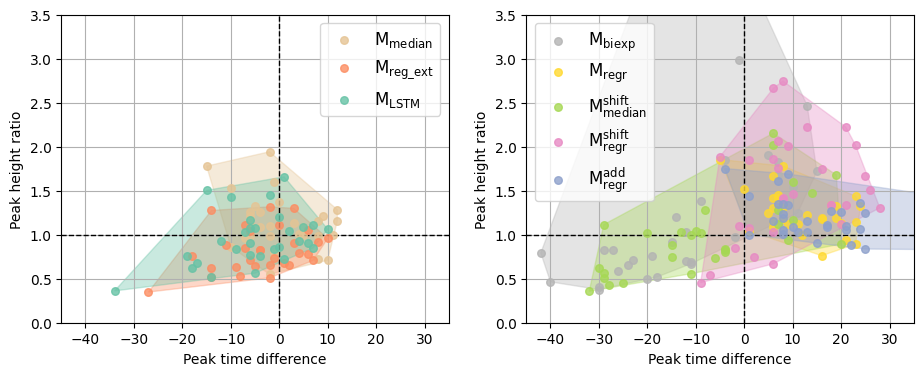

In [ ]:
from scipy.spatial import ConvexHull
import matplotlib as mpl

fig, axes = plt.subplots(1,2,figsize=(11, 4))
axes = axes.flatten()
ax = axes[1]
ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

methods = ['$\mathregular{M_{biexp}}$', '$\mathregular{M_{regr}}$',

            '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$']

new_labels = ['biexponential_decay', 'regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning']

switch = 'type_start_day = roll_var_npeople'

cmap = mpl.colormaps['Set2']
# take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))
colors = list(colors[[2,3,4,5,7]])
for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.8, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')
ax.legend(prop={'size': 12})
ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)

# ____________
ax = axes[0]
ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

cmap = mpl.colormaps['Set2']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))
colors = [*list(colors)[:2], list(colors)[-2]]

methods = ['$\mathregular{M_{median}}$', '$\mathregular{M_{reg\_ext}}$',       
            '$\mathregular{M_{LSTM}}$']

new_labels = ['median_beta','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']

switch = 'type_start_day = roll_var_npeople'

for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.8, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')
ax.legend(prop={'size': 12})
ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)

plt.tight_layout
#plt.savefig(f'results/{switch}/peaks_area.pdf', 
#            format='pdf', bbox_inches='tight')

# start day - constant

In [ ]:
'''
seeds = set()
seeds.update(range(int(0), int(30)))
days = np.array([40,50,60])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
    for beta_prediction_method,new_labels in zip(methods, new_labels):
        all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days = main_f('seir', False, 0, beta_prediction_method, day, seeds, False, False)
        # creating a dataframe for peaks
        all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 'actual_peak_day', 'predicted_peak_day'])
        # creating a dataframe for RMSE, predicted time, start day
        print(len(all_rmse_I),len(all_rmse_Beta), len(execution_time), len(start_days))
        rmse_df = pd.DataFrame({
            'rmse_I': all_rmse_I,
            'rmse_Beta': all_rmse_Beta,
            'time_predict': execution_time,
            f'{day}': start_days})

        # merging dataframes
        results = pd.concat([rmse_df, all_peak], axis=1)
        results.to_csv(f'results/start_day = {day}/{new_labels}_results.csv', index=False)
        '''

"\nseeds = set()\nseeds.update(range(int(0), int(30)))\ndays = np.array([40,50,60])\nfor day in days:\n    methods = ['last value',\n        'rolling mean last value',\n        'expanding mean last value',\n        'biexponential decay', \n        \n        'median beta',\n        'regression (day)',\n\n        'median beta;\nshifted forecast',\n        'regression (day);\nshifted forecast',\n        'regression (day);\nincremental learning',\n        'regression (day, SEIR, previous I)',       \n        'lstm (day, E, previous I)']\n    new_labels = ['last_value',\n        'rolling_mean_last_value',\n        'expanding_mean_last_value',\n        'biexponential_decay', \n        \n        'median_beta',\n        'regression_day',\n\n        'median_beta_shifted_forecast',\n        'regression_day_shifted_forecast',\n        'regression_day_incremental_learning',\n        'regression_day_SEIR_previous_I',       \n        'lstm_day_E_previous_I']\n    for beta_prediction_method,new_label

### Boxplot RMSE for Infected


all beta_prediction_method, start_day = 40, 50, 60

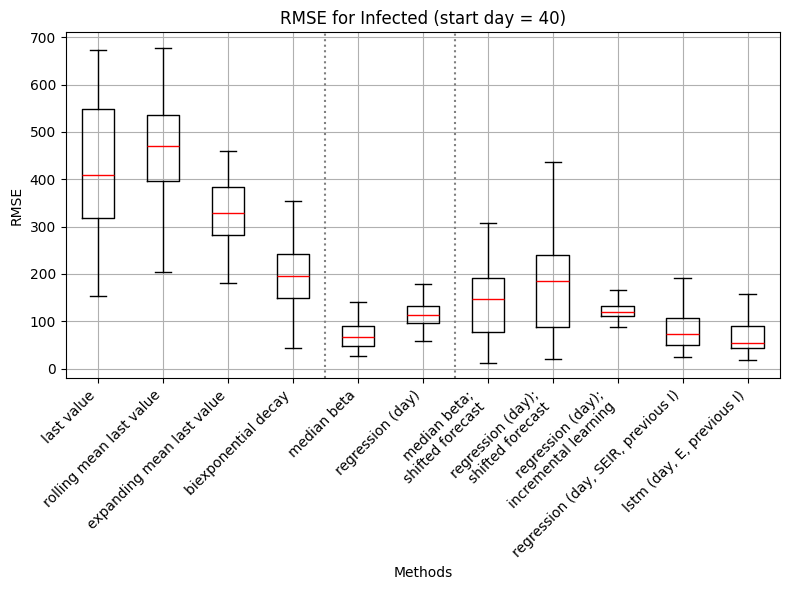

<Figure size 640x480 with 0 Axes>

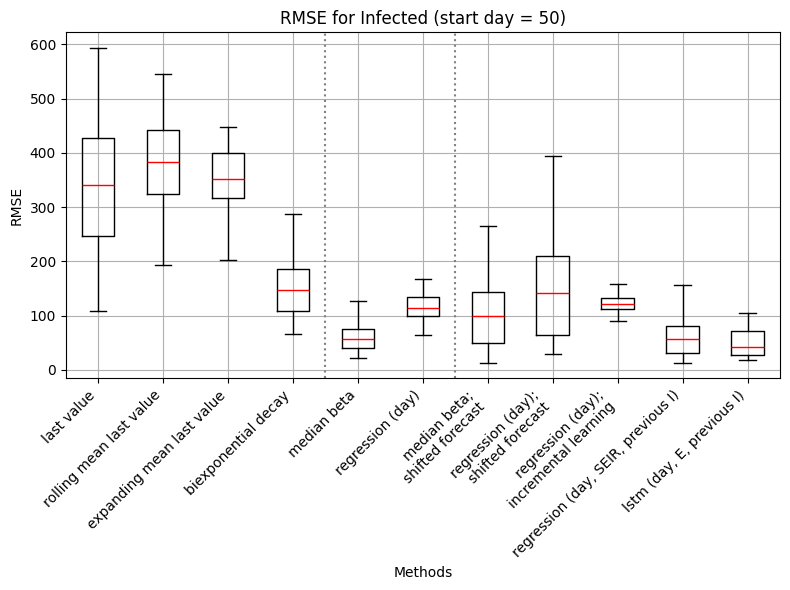

<Figure size 640x480 with 0 Axes>

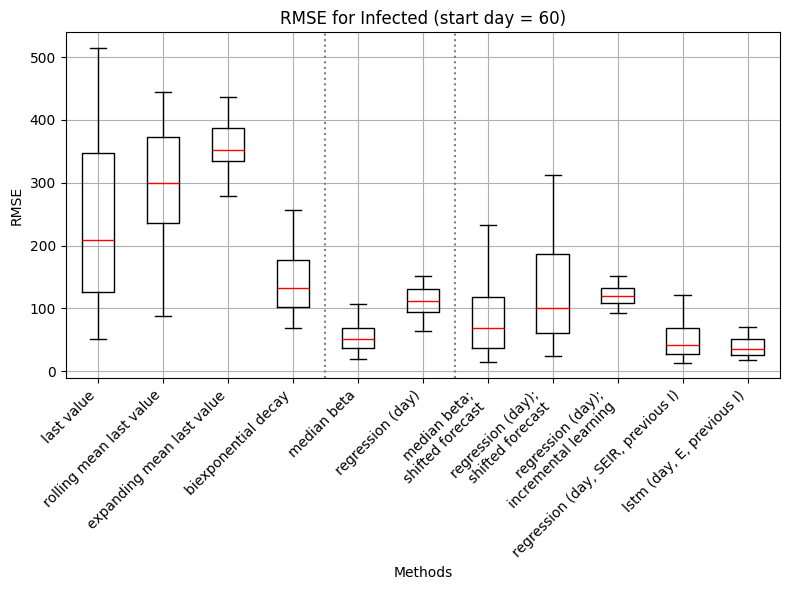

<Figure size 640x480 with 0 Axes>

In [ ]:
days = np.array([40,50,60])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_labels in zip(methods, new_labels):
        # loading data from CSV
        df = pd.read_csv(f'results/start_day = {day}/{new_labels}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']

    # creating a boxplot
    plt.figure(figsize=(8,6))
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='red'),
                      widths=0.5)
    
    plt.title(f'RMSE for Infected (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')
    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    #plt.savefig(f'results/start_day = {day}/rmse_I_boxplot.pdf', 
    #            format='pdf', dpi=300, bbox_inches='tight')    

### Boxplot RMSE for Beta

all beta_prediction_method, start_day = 40, 50, 60

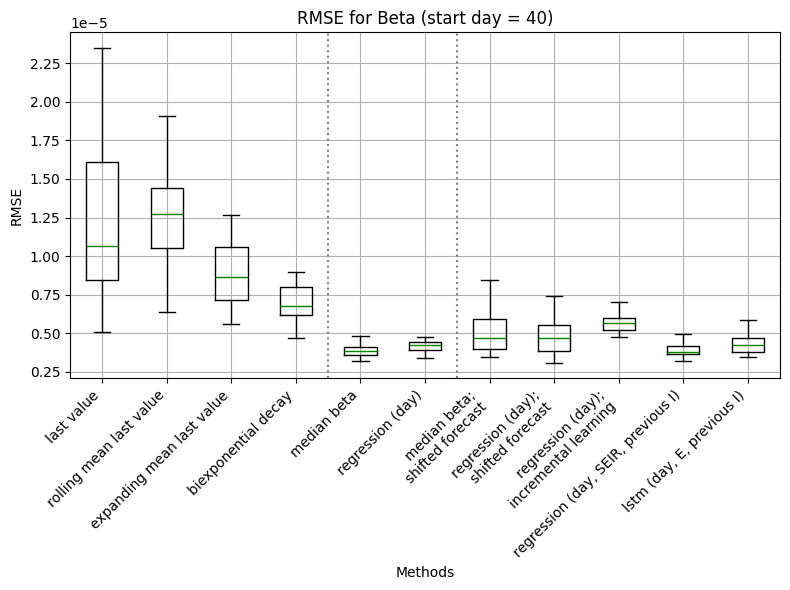

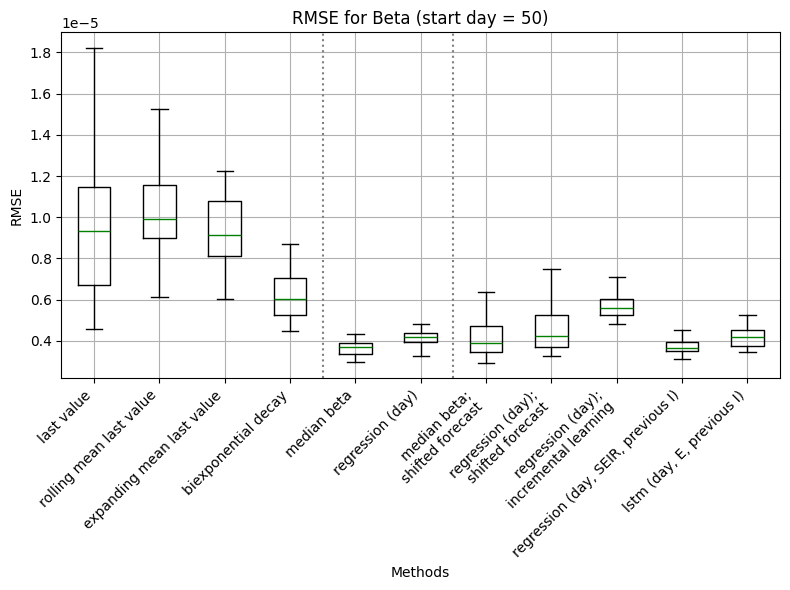

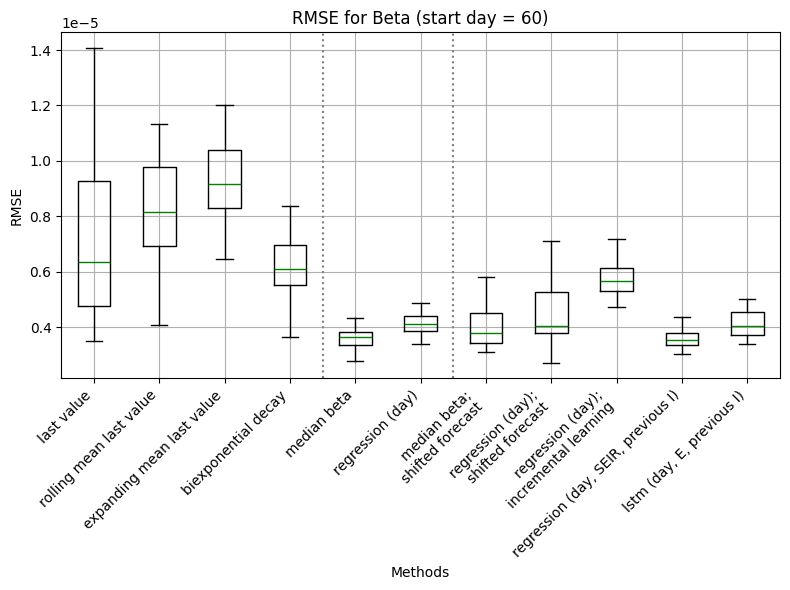

In [ ]:

days = np.array([40,50,60])
for day in days:
    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods, new_labels):
        # loading data from CSV
        df = pd.read_csv(f'results/start_day = {day}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']

    # creating a boxplot
    plt.figure(figsize=(8,6))
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='green'),
                      widths=0.5)

    plt.title(f'RMSE for Beta (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')
    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')
    plt.tight_layout()
    plt.grid()
    plt.show()
    
    #plt.savefig(f'results/{}/rmse_Beta_boxplot.pdf', 
    #            format='pdf', dpi=300, bbox_inches='tight')    

### Show peaks plots

start_day = 50

In [23]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
day = 50

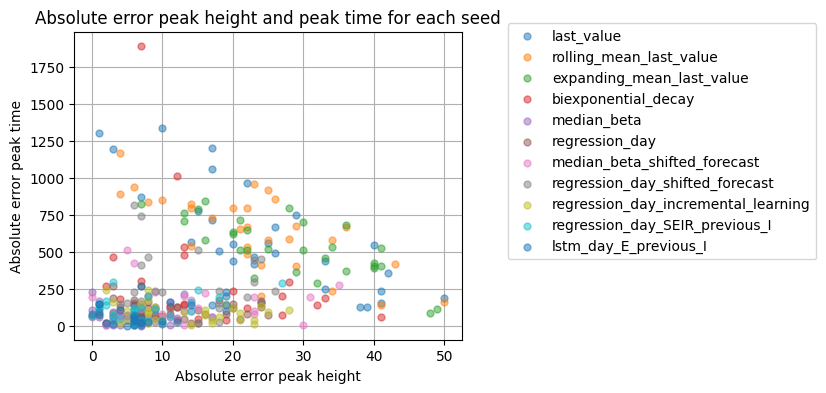

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name, zorder=3)
    
ax.set_title('Absolute error peak height and peak time for each seed')    
ax.set_xlabel('Absolute error peak height')
ax.set_ylabel('Absolute error peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid(True, zorder=1)

#plt.savefig(f'results/start_day = {day}/absolute_error_peaks.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')

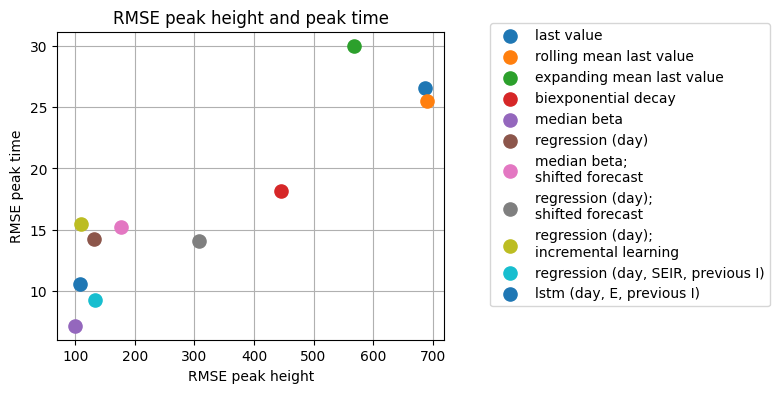

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], 
                        p_df.iloc[:]['predicted_peak_I']))
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], 
                        p_df.iloc[:]['predicted_peak_day']))
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name, zorder=3)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid(True, zorder=1)

#plt.savefig(f'results/start_day = {day}/rmse_peaks.pdf', 
#            format='pdf', dpi=300, bbox_inches='tight')


# pivot tables for all models and switches

In [ ]:
# save by switch method

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value','biexponential_decay', 

                'median_beta','regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']


switches = [f'start_day = {n}' for n in [40,50,60]] + \
            [f'type_start_day = {i}' for i in ['norm_var','roll_var',
                                               'roll_var_npeople','roll_var_seq']]

for switch in switches:
    fin = pd.DataFrame([])
    
    clm_with_switch = switch.split(' = ')[-1]
    clms = ['rmse_I', 'rmse_Beta', 'time_predict', clm_with_switch]
    for m in new_labels:
        df = pd.read_csv(f'results/{switch}/{m}_results.csv')

        q = df[clms].apply(lambda x: [x.median(), x.std()]).T
        ph = df['predicted_peak_I'] - df['actual_peak_I']
        q.loc['pt_diff'] = ph.median(), ph.std()
        pt = df['actual_peak_I']/df['predicted_peak_I']
        q.loc['ph_fraq'] = pt.median(), pt.std()
        q.columns = [[m + '_mean', m + '_std']]
        fin = pd.concat([fin, q], axis=1)
        
    fin.to_csv(f'results/pivot_tables/{clm_with_switch}_pivot.csv')

# switches for 12 and 29 seed


 start day = 10 for seed = 12 and type start day = roll_var
 start day = 63 for seed = 12 and type start day = roll_var_seq
 start day = 63 for seed = 12 and type start day = roll_var_npeople
 start day = 87 for seed = 29 and type start day = roll_var
 start day = 87 for seed = 29 and type start day = roll_var_seq
 start day = 60 for seed = 29 and type start day = roll_var_npeople


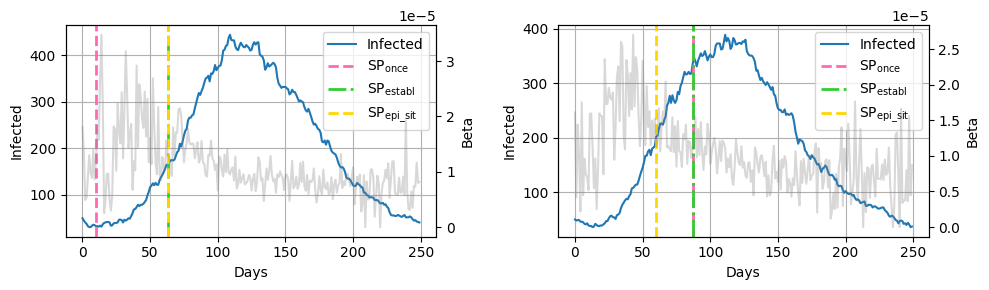

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax = ax.flatten()

for i,seed_number in enumerate([12,29]):
    seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
    seed_df = seed_df[pd.notna(seed_df['Beta'])]

    # displaying the actual Infected values
    ax[i].plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Infected')
    ax_b = ax[i].twinx()
    # displaying the actual Beta values
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
    ax[i].grid()
    colors=['gold','limegreen','hotpink']
    lss=['--','-.','--']
    for sm, lab in zip(['roll_var','roll_var_seq','roll_var_npeople'],
                        ['$\mathregular{SP_{once}}$', 
                         '$\mathregular{SP_{establ}}$', 
                         '$\mathregular{SP_{epi\_sit}}$']):
        c = colors.pop()
        start_day = choice_start_day.choose_method(seed_df, sm)
        ax[i].axvline(start_day, color=c, alpha=1, 
                   lw=2, label=lab, ls=lss.pop())
        print(f' start day = {start_day} for seed = {seed_number} and type start day = {sm}')

    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Infected')
    ax_b.set_ylabel('Beta')
    ax[i].legend(loc='upper right')
    
plt.tight_layout()
#plt.savefig(f'results/12_and_29_seeds_switches.pdf',  
#            format='pdf', bbox_inches='tight')

# several constant Beta

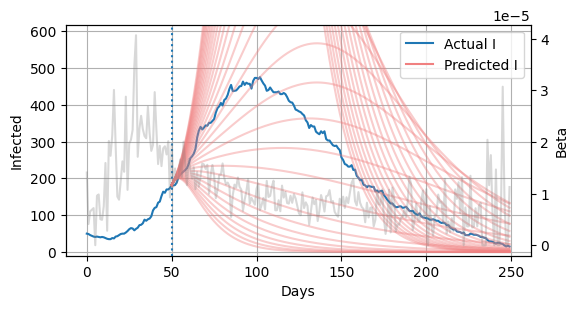

In [ ]:
betas = np.arange(0, 3e-5, 1e-6)
start_day = 50
seed_number = 0
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Actual I')

ax_b = ax.twinx()
ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
ax.axvline(start_day, ls=':')

y = seed_df.iloc[start_day, :4].values
predicted_days = np.arange(start_day, seed_df.shape[0])
for beta in betas:
    if beta == 0:
        label='Predicted I'
    else:
        label=''
    S,E,I,R = predict_Beta_I.predict_I('seir',y, predicted_days, beta, 
                                       0.1, 0.08, stype='d', beta_t=False)
    ax.plot(np.arange(start_day, seed_df.shape[0]), I, 
            color='lightcoral', alpha=0.4, label=label)
    
ll = ax.legend()
for lh in ll.legend_handles:
    lh.set_alpha(1)
ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_ylim(-10, seed_df.I.max()*1.3)
ax.grid()

#plt.savefig(f'results/several_constant_Beta.pdf',  
#            format='pdf', bbox_inches='tight')

# 5 seed graphs for beta_prediction_method groups with start_day = 50

group 1

last value
rolling mean last value
expanding mean last value
biexponential decay


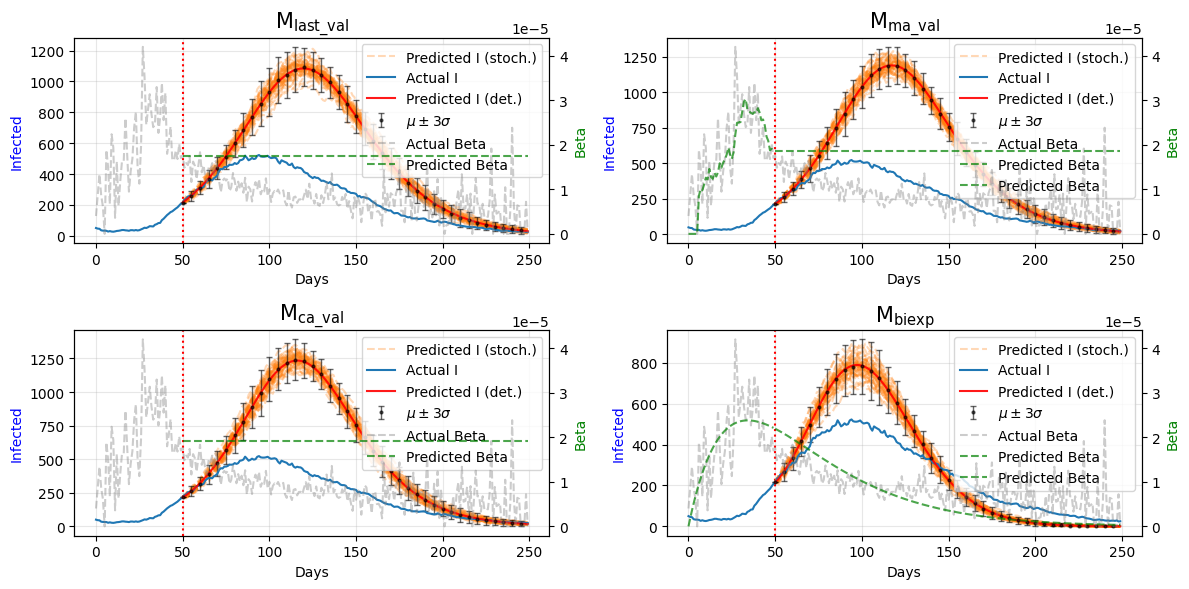

In [ ]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(5), int(6)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(2,2, figsize=(12,6))
axes=ax.flatten()

n = 4

for beta_method, label, i in zip(new_labels[:n], methods[:n], range(n)):
    seeds = set()
    seeds.update(range(int(5), int(6)))
    seed_number = seeds
    predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, ttime = main_f('seir', True, n_s, 
                           beta_method, 50, seed_number, False, False)

    # median calculation
    median_values = np.median(predicted_I, axis=0) 

    # standard error
    std_dev = np.std(predicted_I, axis=0)

    # boundaries: median ± 3σ (checked for negative values)
    lower_bound = median_values - 3 * std_dev
    upper_bound = median_values + 3 * std_dev
    lower_bound = np.maximum(lower_bound, 0)
  

    plot_one(axes[i], predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, ttime, median_values,lower_bound,upper_bound)
    axes[i].set_title(f"{label}",size=15)

plt.tight_layout()  
#plt.savefig(f'results/3sigma_group1.pdf',  
#            format='pdf', bbox_inches='tight')

group 2

median beta
regression (day)


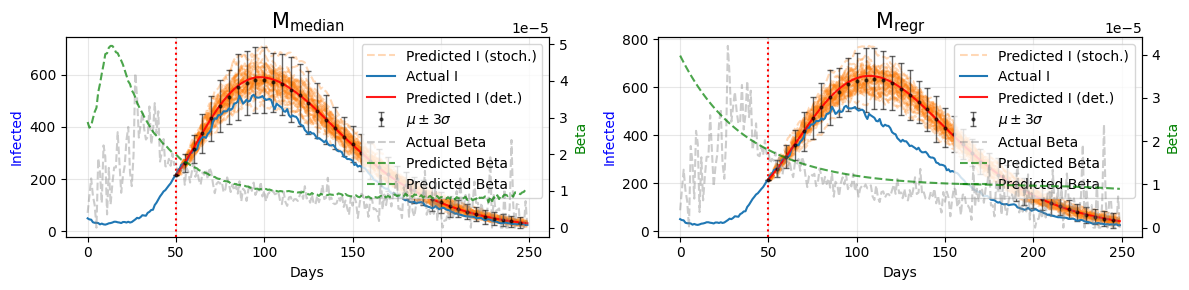

In [ ]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(5), int(6)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(1,2, figsize=(12,3))
axes=ax.flatten()

n = 2

for beta_method, label, i in zip(new_labels[4:6], methods[4:6], range(n)):
    seeds = set()
    seeds.update(range(int(5), int(6)))
    seed_number = seeds
    predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, ttime = main_f('seir', True, n_s, 
                           beta_method, 50, seed_number, False, False)

    # median calculation
    median_values = np.median(predicted_I, axis=0) 

    # standard error
    std_dev = np.std(predicted_I, axis=0)

    # boundaries: median ± 3σ (checked for negative values)
    lower_bound = median_values - 3 * std_dev
    upper_bound = median_values + 3 * std_dev
    lower_bound = np.maximum(lower_bound, 0) 

    plot_one(axes[i], predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, ttime, median_values,lower_bound,upper_bound)
    axes[i].set_title(f"{label}",size=15)

plt.tight_layout()  
#plt.savefig(f'results/3sigma_group2.pdf',  
#            format='pdf', bbox_inches='tight')

group 3

median beta;
shifted forecast
regression (day);
shifted forecast
regression (day);
incremental learning
regression (day, SEIR, previous I)
lstm (day, E, previous I)


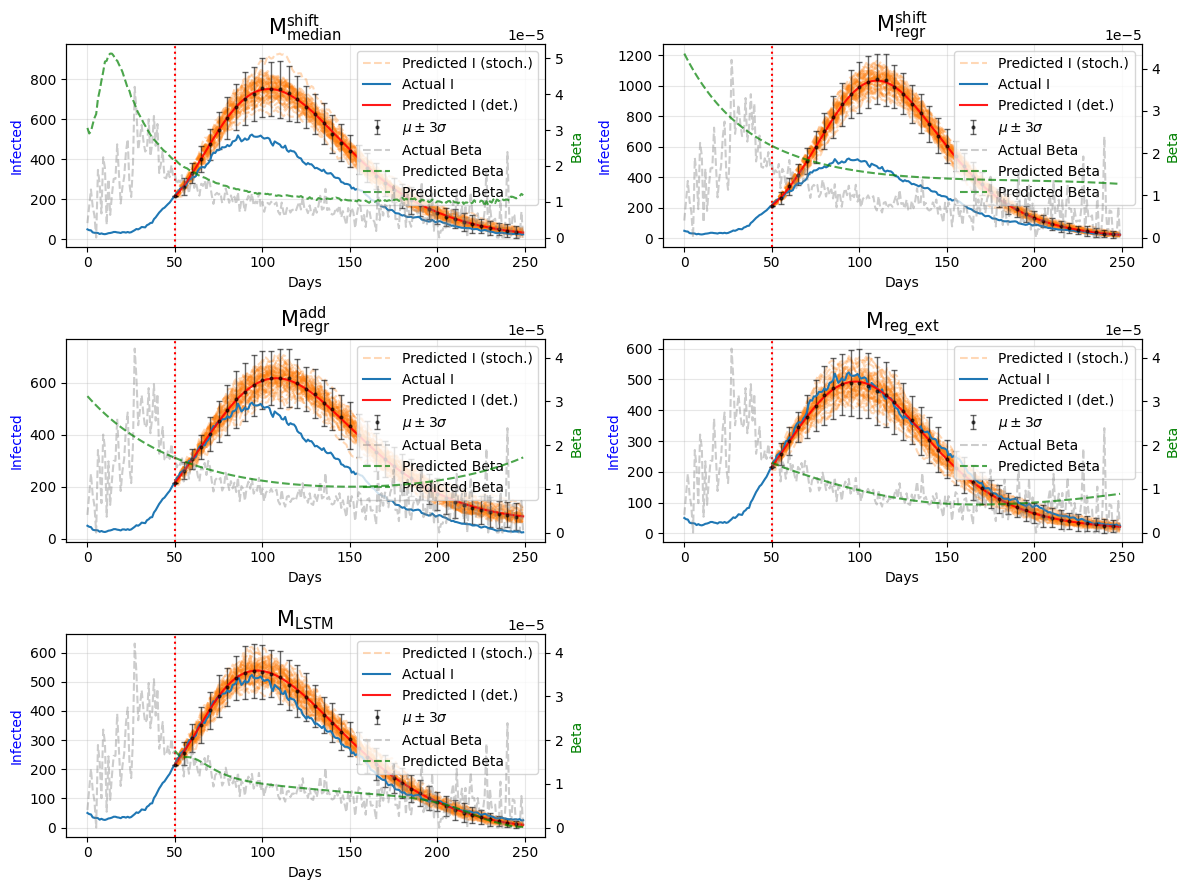

In [ ]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(5), int(6)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(3,2, figsize=(12,9))
axes=ax.flatten()

n = 6

for beta_method, label, i in zip(new_labels[6:], methods[6:], range(n)):
    seeds = set()
    seeds.update(range(int(5), int(6)))
    seed_number = seeds
    predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, ttime = main_f('seir', True, n_s, 
                           beta_method, 50, seed_number, False, False)

    # median calculation
    median_values = np.median(predicted_I, axis=0)  # Медиана по всем I[j]

    # standard error
    std_dev = np.std(predicted_I, axis=0)

    # boundaries: median ± 3σ (checked for negative values)
    lower_bound = median_values - 3 * std_dev
    upper_bound = median_values + 3 * std_dev
    lower_bound = np.maximum(lower_bound, 0)
  
    plot_one(axes[i], predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, ttime, median_values,lower_bound,upper_bound)
    axes[i].set_title(f"{label}",size=15)

fig.delaxes(axes[-1])   
plt.tight_layout()  
#plt.savefig(f'results/3sigma_group3.pdf',  
#            format='pdf', bbox_inches='tight')

# Код графического окна

last value


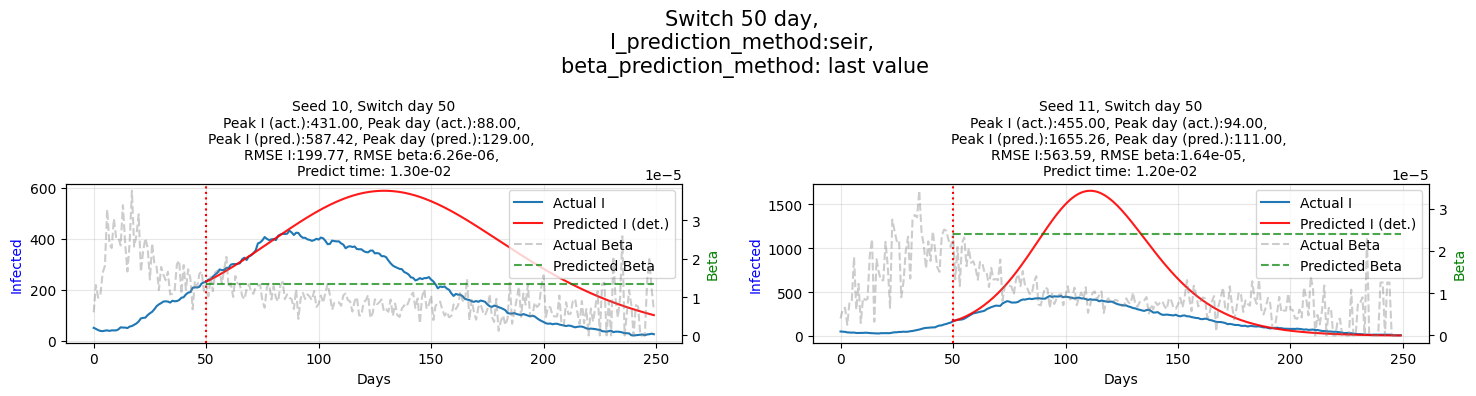

In [ ]:
'''
Create a graphical window for parameter input
'''
def parse_seeds(seeds_input):
    ''' 
    Parse and sort numbers of seeds
    '''

    # Use a set to store unique values
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # Detect range by hyphen
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # Add numbers from range
        else:
            seeds.add(int(part))  # Add individual seed numbers
            
    return sorted(seeds)

def calculate():
    try:
        # Get values from input fields
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        # Get the number of stochastic trajectories if stochastic mode is enabled
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  
        beta_prediction_method = var_beta_prediction_method.get()
        # Get the start day value
        start_day = selected_start_day.get()

        # Convert start day value to an integer if it's '40', '50', or '60'
        if start_day in ['40', '50', '60']:
            start_day = int(start_day)

        seed_numbers = entry_seed_numbers.get()
        # Parse and sort numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # Call the main function
        result = main_f(I_prediction_method, stochastic, count_stoch_line, 
                        beta_prediction_method, start_day, seed_numbers,
                        True, False)
        
        # Display result
        messagebox.showinfo("Result", "Completed")
    except ValueError:
        messagebox.showerror("Error", "Please enter valid data.")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")

# Create main window
root = tk.Tk()
root.title("Parameter Input")

# Create variable for selecting prediction model
var_I_prediction_method = tk.StringVar(value="seir")  # Set default value
# Create dropdown menu for selecting prediction model
label_I_prediction_method = tk.Label(root, text="Infected Prediction Method:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, 
                                             *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# Create checkbox for stochastic mode
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Stochastic", 
                                     variable=var_stochastic, 
                                     command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# Create label and input field for the number of stochastic trajectories
label_count_stoch_line = tk.Label(root, text="Number of Stochastic Trajectories:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # Initially disable input field

# Function to enable/disable input field based on checkbox state
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # Enable input field
    else:
        entry_count_stoch_line.config(state='disabled')  # Disable input field

# Create variable for selecting beta prediction method
var_beta_prediction_method = tk.StringVar(value="last value")  # Set default value
# Create dropdown menu for selecting beta prediction method
label_beta_prediction_method = tk.Label(root, text="Beta Prediction Method:")
label_beta_prediction_method.pack()
beta_prediction_method_options =  ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        'median beta',
        'regression (day)'
        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, 
                                                *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# Create label for start day type
# Variable for selecting start day type
selected_start_day = tk.StringVar(value='50')

# Create dropdown menu for selecting start day type
label_start_day = tk.Label(root, text="Start Day Calculation Type:")
label_start_day.pack()

start_day_options = ['roll_var', 
                     'norm_var', 
                     'roll_var_seq', 
                     'roll_var_npeople', 
                     '40',
                     '50',
                     '60']
dropdown_start_day = tk.OptionMenu(root, selected_start_day, *start_day_options)
dropdown_start_day.pack()

# Create label and input field for seed numbers
label_seed_numbers = tk.Label(root, 
                              text="Seed Numbers (comma-separated or range with hyphen):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# Create button to execute calculation
button_calculate = tk.Button(root, text="Calculate", command=calculate)
button_calculate.pack() 

# Run the main application loop
root.mainloop()
